<a href="https://colab.research.google.com/github/Sauce16/DL-PROJECT/blob/main/DL_LSTM_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
import keras.backend as K
from keras.layers import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn import preprocessing
from tensorflow import keras

In [ ]:
# Setting seed for reproducibility
np.random.seed(1234)
PYTHONHASHSEED = 0

In [ ]:
# read training data - It is the aircraft engine run-to-failure data.
# read test data - It is the aircraft engine operating data without failure events recorded.
# read ground truth data - It contains the information of true remaining cycles for each
#  engine in the testing data.
train_df = pd.read_csv('/content/PM_train.txt', sep=" ", header=None)
test_df = pd.read_csv('/content/PM_test.txt', sep=" ", header=None)
truth_df = pd.read_csv('/content/PM_truth.txt', sep=" ", header=None)

In [ ]:
# Drop missing data columns(redundant)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)

In [ ]:
# Sorting and indicating columns
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

train_df = train_df.sort_values(['id','cycle'])

test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

In [ ]:
train_df

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s12,s13,s14,s15,s16,s17,s18,s19,s20,s21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20626,100,196,-0.0004,-0.0003,100.0,518.67,643.49,1597.98,1428.63,14.62,...,519.49,2388.26,8137.60,8.4956,0.03,397,2388,100.0,38.49,22.9735
20627,100,197,-0.0016,-0.0005,100.0,518.67,643.54,1604.50,1433.58,14.62,...,519.68,2388.22,8136.50,8.5139,0.03,395,2388,100.0,38.30,23.1594
20628,100,198,0.0004,0.0000,100.0,518.67,643.42,1602.46,1428.18,14.62,...,520.01,2388.24,8141.05,8.5646,0.03,398,2388,100.0,38.44,22.9333
20629,100,199,-0.0011,0.0003,100.0,518.67,643.23,1605.26,1426.53,14.62,...,519.67,2388.23,8139.29,8.5389,0.03,395,2388,100.0,38.29,23.0640


In [ ]:
# Data Preprocessing - Train data
# Data Labeling - generate column RUL(Remaining Usefull Life)
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)

# MinMax normalization (from 0 to 1)
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id', 'cycle', 'RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]),
                             columns=cols_normalize,
                             index=train_df.index)
join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns=train_df.columns)

print(train_df)

        id  cycle  setting1  setting2  setting3   s1        s2        s3  \
0        1      1  0.459770  0.166667       0.0  0.0  0.183735  0.406802   
1        1      2  0.609195  0.250000       0.0  0.0  0.283133  0.453019   
2        1      3  0.252874  0.750000       0.0  0.0  0.343373  0.369523   
3        1      4  0.540230  0.500000       0.0  0.0  0.343373  0.256159   
4        1      5  0.390805  0.333333       0.0  0.0  0.349398  0.257467   
...    ...    ...       ...       ...       ...  ...       ...       ...   
20626  100    196  0.477011  0.250000       0.0  0.0  0.686747  0.587312   
20627  100    197  0.408046  0.083333       0.0  0.0  0.701807  0.729453   
20628  100    198  0.522989  0.500000       0.0  0.0  0.665663  0.684979   
20629  100    199  0.436782  0.750000       0.0  0.0  0.608434  0.746021   
20630  100    200  0.316092  0.083333       0.0  0.0  0.795181  0.639634   

             s4   s5  ...       s14       s15  s16       s17  s18  s19  \
0      0.3097

In [ ]:
train_df.iloc[:62, :]

,id,cycle,setting1,setting2,setting3,s1,s2,s3,s4,s5,...,s14,s15,s16,s17,s18,s19,s20,s21,RUL,cycle_norm
0,1,1,0.459770,0.166667,0.0,0.0,0.183735,0.406802,0.309757,0.0,...,0.199608,0.363986,0.0,0.333333,0.0,0.0,0.713178,0.724662,191,0.000000
1,1,2,0.609195,0.250000,0.0,0.0,0.283133,0.453019,0.352633,0.0,...,0.162813,0.411312,0.0,0.333333,0.0,0.0,0.666667,0.731014,190,0.002770
2,1,3,0.252874,0.750000,0.0,0.0,0.343373,0.369523,0.370527,0.0,...,0.171793,0.357445,0.0,0.166667,0.0,0.0,0.627907,0.621375,189,0.005540
3,1,4,0.540230,0.500000,0.0,0.0,0.343373,0.256159,0.331195,0.0,...,0.174889,0.166603,0.0,0.333333,0.0,0.0,0.573643,0.662386,188,0.008310
4,1,5,0.390805,0.333333,0.0,0.0,0.349398,0.257467,0.404625,0.0,...,0.174734,0.402078,0.0,0.416667,0.0,0.0,0.589147,0.704502,187,0.011080
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,1,58,0.419540,0.583333,0.0,0.0,0.207831,0.423370,0.265699,0.0,...,0.165858,0.411697,0.0,0.166667,0.0,0.0,0.612403,0.545568,134,0.157895
58,1,59,0.465517,0.666667,0.0,0.0,0.337349,0.559843,0.358879,0.0,...,0.148983,0.472105,0.0,0.333333,0.0,0.0,0.604651,0.759735,133,0.160665
59,1,60,0.442529,0.333333,0.0,0.0,0.340361,0.255287,0.351452,0.0,...,0.170038,0.242016,0.0,0.416667,0.0,0.0,0.581395,0.680475,132,0.163435
60,1,61,0.522989,0.916667,0.0,0.0,0.268072,0.272727,0.392809,0.0,...,0.163691,0.390535,0.0,0.250000,0.0,0.0,0.581395,0.648440,131,0.166205


In [ ]:
# Data Preprocessing - Test data
# MinMax normalization (from 0 to 1)
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]),
                            columns=cols_normalize,
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns=test_df.columns)
test_df = test_df.reset_index(drop=True)

# We use the ground truth dataset to generate labels for the test data.
# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)

print(test_df)

        id  cycle  setting1  setting2  setting3   s1        s2        s3  \
0        1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661   
1        1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551   
2        1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632   
3        1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154   
4        1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082   
...    ...    ...       ...       ...       ...  ...       ...       ...   
13091  100    194  0.781609  0.500000       0.0  0.0  0.611446  0.619359   
13092  100    195  0.436782  0.416667       0.0  0.0  0.605422  0.537388   
13093  100    196  0.465517  0.250000       0.0  0.0  0.671687  0.482014   
13094  100    197  0.281609  0.583333       0.0  0.0  0.617470  0.522128   
13095  100    198  0.574713  0.750000       0.0  0.0  0.524096  0.666667   

             s4   s5  ...       s14       s15  s16       s17  s18  s19  \
0      0.2694

In [ ]:
# Window size extension to 60
sequence_length = 60

# function to reshape features into (samples, time steps, features)
def gen_sequence(id_df, seq_length, seq_cols):
    data_matrix = id_df[seq_cols].values
    num_elements = data_matrix.shape[0]
    for start, stop in zip(range(0, num_elements - seq_length), range(seq_length, num_elements)):
        yield data_matrix[start:stop, :]


# pick the feature columns
sensor_cols = ['s' + str(i) for i in range(1, 22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

# print(sequence_cols)
# val is a list of 192 - 60 = 142 bi-dimensional array (60 rows x 25 columns)
val = list(gen_sequence(train_df[train_df['id'] == 1], sequence_length, sequence_cols))
print(len(val))

# generator for the sequences
# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id'] == id], sequence_length, sequence_cols))
           for id in train_df['id'].unique())

# generate sequences and convert to numpy array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

132
(14631, 60, 25)


In [ ]:
# function to generate labels
def gen_labels(id_df, seq_length, label):
    data_matrix = id_df[label].values
    num_elements = data_matrix.shape[0]
    return data_matrix[seq_length:num_elements, :]

# generate labels
label_gen = [gen_labels(train_df[train_df['id'] == id], sequence_length, ['RUL'])
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
print(label_array.shape)
print(label_array[:10])


(14631, 1)
[[131.]
 [130.]
 [129.]
 [128.]
 [127.]
 [126.]
 [125.]
 [124.]
 [123.]
 [122.]]


In [ ]:
# Modeling
model_path = 'regression_model.h5'

def r2_keras(y_true, y_pred):
    SS_res = K.sum(K.square(y_true - y_pred))
    SS_tot = K.sum(K.square(y_true - K.mean(y_true)))
    return (1 - SS_res / (SS_tot + K.epsilon()))

# Network Architecture
# The first layer is an LSTM layer with 100 units followed by another LSTM layer with 60 units.
# Dropout is also applied after each LSTM layer to control overfitting.
# Final layer is a Dense output layer with single unit and linear activation
# since this is a regression problem.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

try:
    f = open(model_path)
    print("Trained model already exists")


except IOError:
    print("Initialize a model")
    model = Sequential()
    model.add(LSTM(
        input_shape=(sequence_length, nb_features),
        units=100,
        return_sequences=True))
    model.add(Dropout(0.3))
    model.add(LSTM(
        units=sequence_length,
        return_sequences=False))
    model.add(Dropout(0.3))
    model.add(Dense(units=nb_out))
    model.add(Activation("linear"))
    model.compile(loss='mean_squared_error', optimizer='rmsprop', metrics=['mae', r2_keras])

    print(model.summary())

    bs = 400
    # fit the network
    history = model.fit(seq_array, label_array, epochs=100, batch_size=bs, validation_split=0.1, verbose=1,
                        callbacks=[keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0,mode='min'),
                                   keras.callbacks.ModelCheckpoint(model_path, monitor='val_loss', save_best_only=False,
                                                                   mode='min', verbose=0)]
                        )

    # list all data in history
    print(history.history.keys())

Initialize a model
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 60, 100)           50400     
                                                                 
 dropout (Dropout)           (None, 60, 100)           0         
                                                                 
 lstm_1 (LSTM)               (None, 60)                38640     
                                                                 
 dropout_1 (Dropout)         (None, 60)                0         
                                                                 
 dense (Dense)               (None, 1)                 61        
                                                                 
 activation (Activation)     (None, 1)                 0         
                                                                 
Total params: 89101 (348.05 KB)
Train

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


33/33 [==============================] - 20s 622ms/step - loss: 7130.9102 - mae: 66.4162 - r2_keras: -1.4667 - val_loss: 9738.9863 - val_mae: 77.4406 - val_r2_keras: -1.8692
Epoch 3/100
33/33 [==============================] - 18s 559ms/step - loss: 6865.6582 - mae: 64.7802 - r2_keras: -1.3743 - val_loss: 9435.2812 - val_mae: 75.8214 - val_r2_keras: -1.7601
Epoch 4/100
33/33 [==============================] - 21s 634ms/step - loss: 6618.3130 - mae: 63.2534 - r2_keras: -1.2902 - val_loss: 9144.7920 - val_mae: 74.2793 - val_r2_keras: -1.6563
Epoch 5/100
33/33 [==============================] - 19s 565ms/step - loss: 6380.8789 - mae: 61.7995 - r2_keras: -1.2082 - val_loss: 8861.9355 - val_mae: 72.7843 - val_r2_keras: -1.5559
Epoch 6/100
33/33 [==============================] - 20s 593ms/step - loss: 6143.8213 - mae: 60.3900 - r2_keras: -1.1254 - val_loss: 8586.7490 - val_mae: 71.3368 - val_r2_keras: -1.4588
Epoch 7/100
33/33 [==============================] - 19s 565ms/step - loss: 5927.9

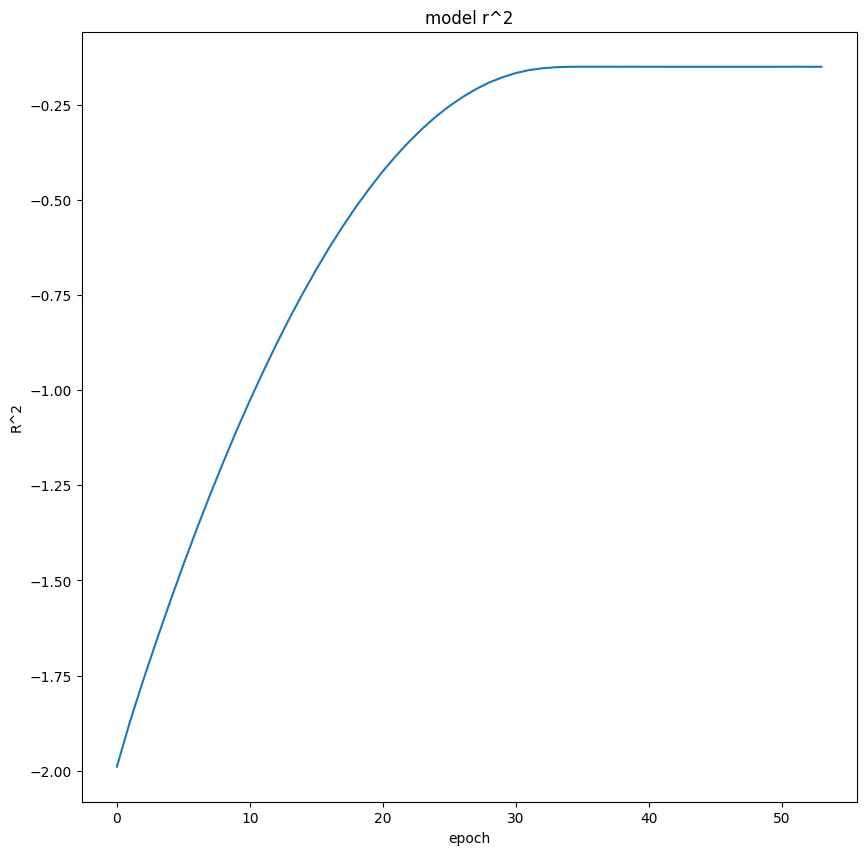

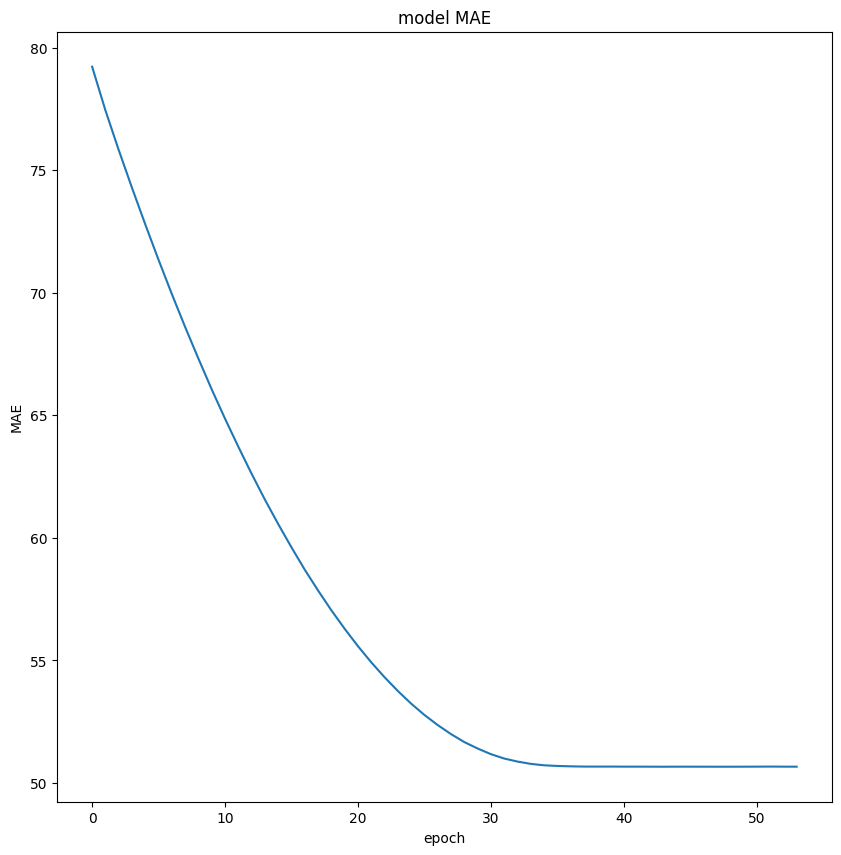

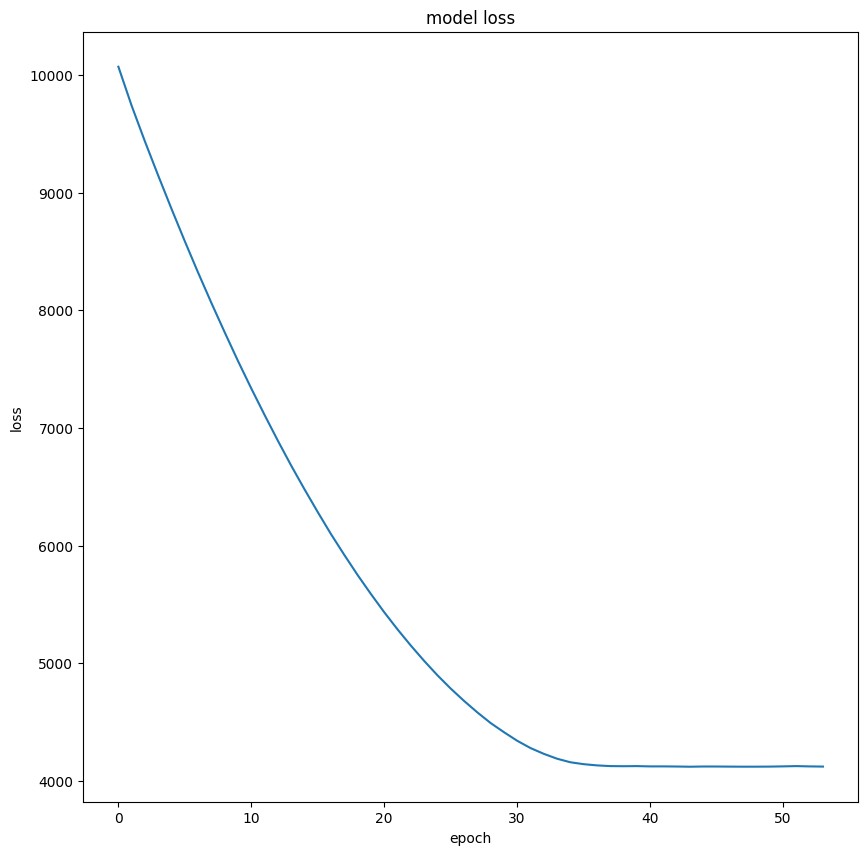

In [ ]:
# summarize history for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.show()
fig_acc.savefig("model_r2.png")

# summarize history for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['val_mae'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.show()
fig_acc.savefig("model_mae.png")

# summarize history for Loss
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()
fig_acc.savefig("model_regression_loss.png")

In [ ]:
# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=bs)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

y_pred = model.predict(seq_array, verbose=1, batch_size=bs)
y_true = label_array

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index=None)

37/37 [==============================] - 7s 201ms/step - loss: 3023.9824 - mae: 44.0437 - r2_keras: -0.0958

MAE: 44.0436897277832

R^2: -0.09582436084747314
37/37 [==============================] - 8s 199ms/step


seq_array_test_last
(88, 60, 25)
3/3 - 1s - loss: 1747.5782 - mae: 36.1818 - r2_keras: -4.6432e-02 - 961ms/epoch - 320ms/step

MAE: 36.181819915771484

R^2: -0.04643185809254646
3/3 [==============================] - 1s 22ms/step
       y_pred  y_truth       diff    diff(%)
0   78.197372     69.0   9.197372   0.133295
1   78.197372     82.0   3.802628   0.046374
2   78.197372     91.0  12.802628   0.140688
3   78.197372     93.0  14.802628   0.159168
4   78.197365     91.0  12.802635   0.140688
5   78.197372     95.0  16.802628   0.176870
6   78.197365     96.0  17.802635   0.185444
7   78.197365     97.0  18.802635   0.193842
8   78.197365    124.0  45.802635   0.369376
9   78.197372     95.0  16.802628   0.176870
10  78.197380     83.0   4.802620   0.057863
11  78.197365     84.0   5.802635   0.069079
12  78.197365     50.0  28.197365   0.563947
13  78.197372     28.0  50.197372   1.792763
14  78.197365     87.0   8.802635   0.101180
15  78.197365     16.0  62.197365   3.887335
16  7

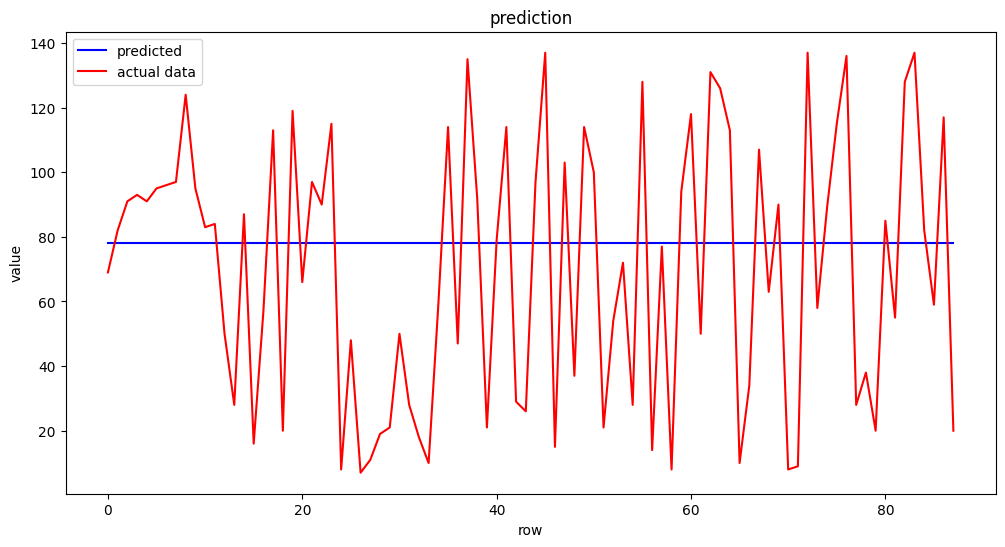

In [ ]:
# Test data validation

# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id'] == id][sequence_cols].values[-sequence_length:]
                       for id in test_df['id'].unique() if len(test_df[test_df['id'] == id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
print("seq_array_test_last")
# print(seq_array_test_last)
print(seq_array_test_last.shape)

# Similarly, we pick the labels
# print("y_mask")
y_mask = [len(test_df[test_df['id'] == id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0], 1).astype(np.float32)
# print(label_array_test_last.shape)

# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path, custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last


    pd.set_option('display.max_rows', 1000)
    test_print = pd.DataFrame()
    test_print['y_pred']  = y_pred_test.flatten()
    test_print['y_truth'] = y_true_test.flatten()
    test_print['diff'] = abs(y_pred_test.flatten() - y_true_test.flatten())
    test_print['diff(%)'] = abs(y_pred_test.flatten() - y_true_test.flatten())/y_true_test.flatten()
    print (test_print)



    test_set = pd.DataFrame(y_pred_test)
    test_set.to_csv('submit_test.csv', index=None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(12, 6))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="red")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")